In [1]:
import os 

import pandas as pd 
import numpy as np 
from tqdm import tqdm
import glob

import torch
import torch.nn as nn 
from torch.utils.data import DataLoader

from torchvision import transforms
import torch.nn.functional as F
import nibabel as nib

from sklearn.model_selection import KFold

import matplotlib.pyplot as plt 

from monai.transforms import *
from monai.utils import set_determinism, first

from monai.data import (
    DataLoader,
    Dataset,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

2024-06-06 11:21:34.113385: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-06 11:21:34.147597: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-06 11:21:34.147627: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-06 11:21:34.147647: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-06 11:21:34.153827: I tensorflow/core/platform/cpu_feature_g

In [2]:
from dp_model.model_files.multi_sfcn import MultiSFCN
from dp_model import dp_loss as dpl
from dp_model import dp_utils as dpu
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [3]:
csv = './IXI_train.csv'
df = pd.read_csv(csv)
df

,idx,f,age,sex,height,weight
0,1,IXI002-Guys-0828-T1.nii.gz,35.800137,2,164,58
1,2,IXI012-HH-1211-T1.nii.gz,38.781656,1,175,70
2,3,IXI013-HH-1212-T1.nii.gz,46.710472,1,182,70
3,4,IXI014-HH-1236-T1.nii.gz,34.236824,2,163,65
4,5,IXI015-HH-1258-T1.nii.gz,24.284736,1,181,90
...,...,...,...,...,...,...
495,496,IXI648-Guys-1107-T1.nii.gz,47.723477,1,193,120
496,497,IXI651-Guys-1118-T1.nii.gz,50.395619,1,175,61
497,498,IXI652-Guys-1116-T1.nii.gz,42.989733,1,163,80
498,499,IXI653-Guys-1122-T1.nii.gz,46.220397,1,172,100


In [4]:
TRAIN_CSV_PATH = './IXI_train.csv'
DATA_PATH = '/mnt/babymri/data_age_mni1mm'

In [5]:
pwd

'/home/oj/ycm'

In [6]:
# 프로젝트 폴더 생성
project_name = "multi_sfcn"
data_root = '/home/oj/ycm'
    
# for name in subdir_li:
#     subdir_path = f'{dir_path}/{name}'
#     if os.path.exists(subdir_path) == False :
#         os.mkdir(subdir_path)

## 3D_T1_reg_PD.nii.gz 있는 폴더만 가져오기

In [7]:
## 3D_T1_reg_PD.nii.gz가 nas에 있으면 가져오기

import glob

# data_pattern = '/mnt/babymri/data_age_mni1mm/*/TOF_bet.nii.gz'
data_pattern = '/mnt/babymri/data_age_mni1mm/*/T1_aseg.nii.gz'

# 해당 패턴에 매칭되는 모든 파일 경로 가져오기
all_files = glob.glob(data_pattern, recursive=True)

# '3D_T1_reg_PD.nii.gz' 파일이 있는 디렉토리만 추출
directories_with_file = [os.path.dirname(file) for file in all_files if os.path.isfile(file)]

# 결과 출력
# for directory in directories_with_file:
#     print(directory)

print(len(directories_with_file))

477


In [8]:
## csv f축 가져오기

image_paths = []
labels = []
for idx, row in df.iterrows(): # df 각 row 돌면서 index랑 row 정보(tuple) 저장
    filename = os.path.join(DATA_PATH, row['f'].replace('-T1.nii.gz', ''))

    if os.path.exists(filename):
        image_paths.append(filename)
print(len(image_paths))

488


In [9]:
## csv와 nas에 둘다 존재하는 파일 + 3D_T1_reg_PD.nii.gz 존재

exist_image = []
for image in directories_with_file:
    if image in image_paths:
        exist_image.append(image)
        
print(len(exist_image))

442


In [10]:
## image, label 가져오기

image_paths = []
tof_paths = []
mask_paths = []
labels = []
for idx, row in df.iterrows(): # df 각 row 돌면서 index랑 row 정보(tuple) 저장
    filename = os.path.join(DATA_PATH, row['f'].replace('-T1.nii.gz', ''))
#     filename = os.path.join(DATA_PATH, row['f'].replace('-T1.nii.gz', ''), 'nifti', '3D_T1_reg_PD.nii.gz')
    if filename in exist_image:
        t1name = os.path.join(filename, 'T1_bet.nii.gz')
        tofname = os.path.join(filename, 'TOF_bet.nii.gz')
        maskname = os.path.join(filename, 'T1_aseg.nii.gz')
        image_paths.append(t1name)
        tof_paths.append(tofname)
        mask_paths.append(maskname)
        labels.append(int(row['age']))
print(len(image_paths),len(tof_paths),len(mask_paths), len(labels))

442 442 442 442


In [11]:
data_ind = np.arange(0,len(image_paths))
data_dict = [
    {
        "t1": image_paths[ind],
        "tof": tof_paths[ind],
        "mask": mask_paths[ind],
        "label": labels[ind]
    }
    for ind in data_ind
]

train_Data = data_dict[88:]
val_Data = data_dict[:88]
n_train = len(train_Data)
n_valid = len(val_Data)

In [12]:
train_transform =Compose([
    LoadImaged(keys=["t1","tof"]),
    EnsureChannelFirstd(keys=["t1","tof"]),
    # RandGaussianSmoothd(
    #     keys=["t1","tof"],
    #     sigma_x=(0.25, 1.5),
    #     sigma_y=(0.25, 1.5),
    #     sigma_z=(0.25, 1.5),
    #     approx="erf",
    #     prob=0.3,
    #     allow_missing_keys=False,
    # ),
    # RandGaussianNoised(keys=["t1","tof"],
    #                        prob=0.5, mean=0, std=25, 
    #                        allow_missing_keys=False), 
    CenterSpatialCropd(
        keys=["t1","tof"],
        roi_size=(164,192,164)  
    ),
    RandSpatialCropd(keys=["t1","tof"],
                         roi_size=(160,192,160), 
                         max_roi_size=None, 
                         random_center=True, 
                         random_size=False
                        ),
    # RandFlipd(
    #         keys=["t1","tof"],
    #         spatial_axis=[0],
    #         prob=0.5,
    #     ),
    ToTensord(
        keys=["t1","tof"]
    ),
])

valid_transform = Compose([
    LoadImaged(keys=["t1","tof", "mask"]),
    EnsureChannelFirstd(keys=["t1","tof","mask"]),
    CenterSpatialCropd(
        keys=["t1","tof","mask"],
        roi_size=(160,192,160)  
    ),
    ToTensord(
        keys=["t1","tof","mask"]
    ),
])

In [13]:
train_ds = Dataset(
    data=train_Data,
    transform=valid_transform,
)
train_loader = DataLoader(
    train_ds, batch_size=2, shuffle=True,
)

In [14]:
val_ds = Dataset(
    data=val_Data,
    transform=valid_transform,
)
valid_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, 
)

In [15]:
all_ds = Dataset(
    data=data_dict,
    transform=valid_transform,
)
all_loader = DataLoader(
    all_ds, batch_size=1, shuffle=False, 
)

In [16]:
t1_tof_strange_idx = [0, 7, 10, 14, 19, 25, 28, 36, 44, 52, 55, 67, 94, 126, 142, 148, 196, 246, 253, 269, 295, 296, 302, 314, 326, 327, 365,
397, 410]
t1_strange_idx = [0, 10, 14, 44, 55, 67, 148, 149, 158, 202, 212, 246, 253, 292, 295, 296, 302, 314, 322, 324, 327, 366, 370]
tof_strange_idx = [0, 7, 14, 44, 55, 67, 103, 142, 327, 365, 410]

In [17]:
def filter_data_by_indices(data_dict, indices):
    filtered_data = [data_dict[i] for i in indices]
    return filtered_data

In [18]:
t1_tof_strange_data = filter_data_by_indices(data_dict, t1_tof_strange_idx)
t1_strange_data = filter_data_by_indices(data_dict, t1_strange_idx)
tof_strange_data = filter_data_by_indices(data_dict, tof_strange_idx)
print(len(t1_tof_strange_data), len(t1_strange_data), len(tof_strange_data))

29 23 11


In [19]:
t1_tof_ds = Dataset(
    data=t1_tof_strange_data,
    transform=valid_transform,
)
t1_tof_loader = DataLoader(
    t1_tof_ds, batch_size=1, shuffle=False, 
)
t1_ds = Dataset(
    data=t1_strange_data,
    transform=valid_transform,
)
t1_loader = DataLoader(
    t1_ds, batch_size=1, shuffle=False, 
)
tof_ds = Dataset(
    data=tof_strange_data,
    transform=valid_transform,
)
tof_loader = DataLoader(
    tof_ds, batch_size=1, shuffle=False, 
)

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiSFCN(nn.Module):
    def __init__(self, channel_number=[32, 64, 128, 256, 256, 64], output_dim=40, dropout=True):
        super(MultiSFCN, self).__init__()
        n_layer = len(channel_number)
        
        # Define encoders for each contrast
        self.encoder1 = self._make_encoder(channel_number)
        self.encoder2 = self._make_encoder(channel_number)
        
        # Classifier
        self.x1_classifier = self._make_classifier(channel_number[-1], output_dim, dropout)
        self.x2_classifier = self._make_classifier(channel_number[-1], output_dim, dropout)
        self.classifier = self._make_classifier(128, output_dim, dropout)  # Multiply by 2 for concatenated features

    def _make_encoder(self, channel_number):
        encoder = nn.Sequential()
        n_layer = len(channel_number)
        for i in range(n_layer):
            if i == 0:
                in_channel = 1  # Input channels for the first layer
            else:
                in_channel = channel_number[i-1]  # Input channels for subsequent layers
            out_channel = channel_number[i]
            if i < n_layer-1:
                encoder.add_module('conv_%d' % i, self.conv_layer(in_channel,
                                                                       out_channel,
                                                                       maxpool=True,
                                                                       kernel_size=3,
                                                                       padding=1))
            else:
                encoder.add_module('conv_%d' % i, self.conv_layer(in_channel,
                                                                       out_channel,
                                                                       maxpool=False,
                                                                       kernel_size=1,
                                                                       padding=0))
        return encoder
    def _upsample(self, in_channels, out_channels):
        # Define upsampling layers
        upsample = nn.Sequential(
            nn.ConvTranspose3d(in_channels=40, out_channels=64, kernel_size=(5,6,5), stride=1, padding=0),
            nn.ReLU()
        )
        # Apply upsampling
        return upsample
        
    def _make_combine_conv(self, in_channels, out_channels):
        layer = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=1, padding=0),
            nn.BatchNorm3d(out_channels),
            nn.ReLU()
        )

        return layer
        
    def _make_classifier(self, in_channels, output_dim, dropout):
        classifier = nn.Sequential()
        avg_shape = [5, 6, 5]
        classifier.add_module('average_pool', nn.AvgPool3d(avg_shape))
        if dropout is True:
            classifier.add_module('dropout', nn.Dropout(0.5))
        classifier.add_module('conv', nn.Conv3d(in_channels, output_dim, padding=0, kernel_size=1))
        return classifier

    @staticmethod
    def conv_layer(in_channel, out_channel, maxpool=True, kernel_size=3, padding=0, maxpool_stride=2):
        if maxpool is True:
            layer = nn.Sequential(
                nn.Conv3d(in_channel, out_channel, padding=padding, kernel_size=kernel_size),
                nn.BatchNorm3d(out_channel),
                nn.MaxPool3d(2, stride=maxpool_stride),
                nn.ReLU()
            )
        else:
            layer = nn.Sequential(
                nn.Conv3d(in_channel, out_channel, padding=padding, kernel_size=kernel_size),
                nn.BatchNorm3d(out_channel),
                nn.ReLU()
            )
        return layer

    def forward(self, x):
        # Forward pass through each encoder
        x1 = x[:, 0, ...]
        x2 = x[:, 1, ...]
        x1_f = self.encoder1(x1) #[bs, 64, 5, 6, 5]
        x2_f = self.encoder2(x2)

        combined_features = torch.cat((x1_f, x2_f), dim=1) # [bs, 128, 5, 6, 5]

        output = self.classifier(combined_features) # [bs, 40, 1, 1, 1]
        x1_out = self.x1_classifier(x1_f)
        x2_out = self.x2_classifier(x2_f)
        
        output = F.log_softmax(output, dim=1)
        x1_out = F.log_softmax(x1_out, dim=1)
        x2_out = F.log_softmax(x2_out, dim=1)
        
        return output, x1_out, x2_out


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"GPU CHECK : {True if device.type == 'cuda' else False}")

model = MultiSFCN()
model = torch.nn.DataParallel(model)
model = model.to(device)

model

GPU CHECK : True


DataParallel(
  (module): MultiSFCN(
    (encoder1): Sequential(
      (conv_0): Sequential(
        (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ReLU()
      )
      (conv_1): Sequential(
        (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ReLU()
      )
      (conv_2): Sequential(
        (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil

In [22]:
bin_range = [12,92]
bin_step = 2
sigma = 2

In [23]:
label = [20,80]
y, bc = dpu.num2vect(label, bin_range, bin_step, sigma)
y = torch.tensor(y, dtype=torch.float32)

## Inference

In [114]:
model.load_state_dict(torch.load("./new_multi_sfcn/1/models/model_4.699.pth", map_location=device))

<All keys matched successfully>

In [115]:
from sklearn.metrics import mean_absolute_error

def calculate_mae(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    return mae

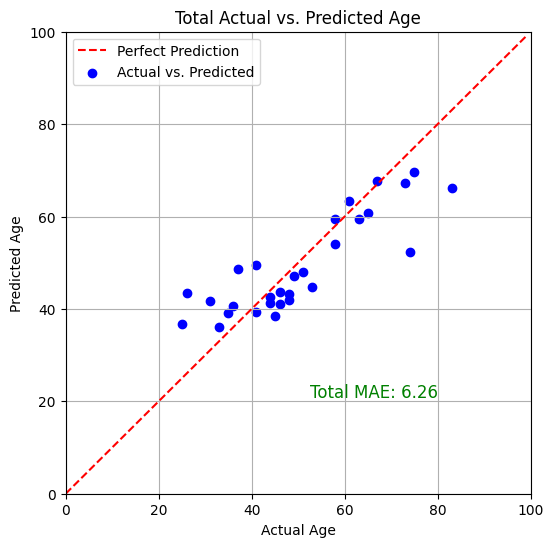

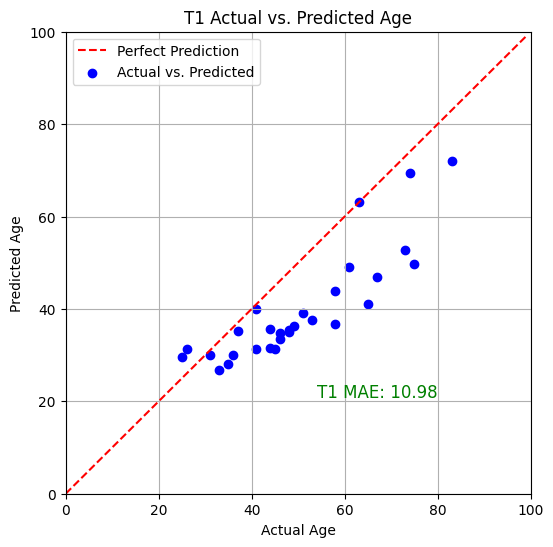

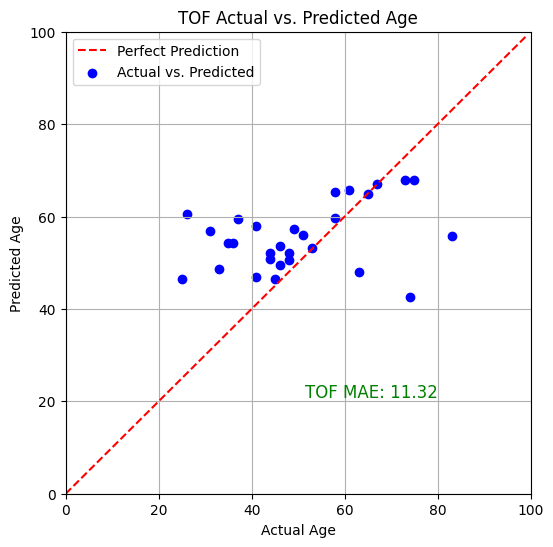

In [116]:
actual_age = np.array([]) 
total_predicted_age = np.array([])
t1_predicted_age = np.array([])
tof_predicted_age = np.array([])

t1_tof_strange_idx = []
t1_strange_idx = []
tof_strange_idx = []

model.to(device)

with torch.no_grad():
    model.eval()
    for step, batch in enumerate(t1_tof_loader):
        t1, tof, labels = batch["t1"].to(device), batch["tof"].to(device), batch["label"]
        
        bs = len(t1)
        
        t1 = t1 / t1.mean()
        tof = tof / tof.mean()
        inputs = torch.stack((t1, tof), dim=1)
        
        outputs,  t1_outputs, tof_outputs = model(inputs)
        
        x = outputs[0].detach().cpu().squeeze()
        prob = np.exp(x)
        pred = prob @ bc

        t1_r = t1_outputs[0].detach().cpu().squeeze()
        t1_prob = np.exp(t1_r.numpy())
        t1_pred = t1_prob @ bc

        tof_r = tof_outputs[0].detach().cpu().squeeze()
        tof_prob = np.exp(tof_r.numpy())
        tof_pred = tof_prob @ bc
        
        actual_age = np.append(actual_age, labels.cpu().numpy())
        total_predicted_age = np.append(total_predicted_age, pred)
        t1_predicted_age = np.append(t1_predicted_age, t1_pred)
        tof_predicted_age = np.append(tof_predicted_age, tof_pred)

        if(np.abs(pred - t1_pred) >= 10):
            t1_strange_idx.append(step)
        if(np.abs(pred - tof_pred) >= 10):
            tof_strange_idx.append(step)
        if(np.abs(t1_pred - tof_pred) >= 15):
            t1_tof_strange_idx.append(step)

    # Plot 1: Total Actual vs. Predicted Age
    plt.figure(figsize=(6, 6))
    plt.plot(np.arange(0, 100), np.arange(0, 100), linestyle='--', color='red', label='Perfect Prediction')
    plt.scatter(actual_age, total_predicted_age, color='blue', label='Actual vs. Predicted')
    plt.axis([0, 100, 0, 100])
    plt.grid('minor')
    mae_total = calculate_mae(actual_age, total_predicted_age)
    plt.text(80, 20, f'Total MAE: {mae_total:.2f}', verticalalignment='bottom', horizontalalignment='right', color='green', fontsize=12)
    plt.xlabel('Actual Age')
    plt.ylabel('Predicted Age')
    plt.title('Total Actual vs. Predicted Age')
    plt.legend()
    # plt.savefig('./new_multi_sfcn/1/total_age.png')
    plt.show()

    # Plot 2: T1 Actual vs. Predicted Age
    plt.figure(figsize=(6, 6))
    plt.plot(np.arange(0, 100), np.arange(0, 100), linestyle='--', color='red', label='Perfect Prediction')
    plt.scatter(actual_age, t1_predicted_age, color='blue', label='Actual vs. Predicted')
    plt.axis([0, 100, 0, 100])
    plt.grid('minor')
    mae_t1 = calculate_mae(actual_age, t1_predicted_age)
    plt.text(80, 20, f'T1 MAE: {mae_t1:.2f}', verticalalignment='bottom', horizontalalignment='right', color='green', fontsize=12)
    plt.xlabel('Actual Age')
    plt.ylabel('Predicted Age')
    plt.title('T1 Actual vs. Predicted Age')
    plt.legend()
    # plt.savefig('./new_multi_sfcn/1/t1_age.png')
    plt.show()

    # Plot 3: TOF Actual vs. Predicted Age
    plt.figure(figsize=(6, 6))
    plt.plot(np.arange(0, 100), np.arange(0, 100), linestyle='--', color='red', label='Perfect Prediction')
    plt.scatter(actual_age, tof_predicted_age, color='blue', label='Actual vs. Predicted')
    plt.axis([0, 100, 0, 100])
    plt.grid('minor')
    mae_tof = calculate_mae(actual_age, tof_predicted_age)
    plt.text(80, 20, f'TOF MAE: {mae_tof:.2f}', verticalalignment='bottom', horizontalalignment='right', color='green', fontsize=12)
    plt.xlabel('Actual Age')
    plt.ylabel('Predicted Age')
    plt.title('TOF Actual vs. Predicted Age')
    plt.legend()
    # plt.savefig('./new_multi_sfcn/1/tof_age.png')
    plt.show()
